In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification #Used for dummy data
from random import randrange
from datetime import timedelta, datetime
from sklearn.metrics import roc_curve, auc, average_precision_score, roc_auc_score,plot_precision_recall_curve, plot_roc_curve
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
import tensorflow_docs as tfdocs
import joblib
import os

Using TensorFlow backend.


Define save path to save models to during training

In [2]:
save_path = "/Users/nostberg/Downloads/triage_test_models/"

#### Generate dummy data for testing

In [3]:
#From StackOverflow: https://stackoverflow.com/questions/553303/generate-a-random-date-between-two-other-dates
def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

d1 = datetime.strptime('1/1/2015 12:00 AM', '%m/%d/%Y %I:%M %p')
d2 = datetime.strptime('12/31/2019 11:59 PM', '%m/%d/%Y %I:%M %p')

rand_date = np.array([random_date(d1,d2) for i in range(500)]).reshape([500,1])


X, y = make_classification(n_samples = 500, n_features=5, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1, class_sep=0.5)
X = np.append(rand_date, X, axis = 1)

In [4]:
"""
When we get real data, inset here 

X = pd.read_csv()
"""


print("There are %d samples and %d features in the whole dataset" %(X.shape[0], X.shape[1]))

There are 500 samples and 6 features in the whole dataset


#### Perform time-based train test split

I'm assuming that we are going to perform our time split in ED arrival time as this will be constant across all experiments?

In [5]:
ED_arrival_idx = 0

#Date at which to perform the train-validation split
validation_time_split = datetime(2018,1,1, 0,0,0) #Format is year, month, day, hour, minute, seconds
test_time_split = datetime(2019, 1,1,0,0,0)

#Generate boolean vectors for time splitting
train_set_idx = X[:,ED_arrival_idx] < validation_time_split
validation_set_idx = (X[:,ED_arrival_idx] > validation_time_split ) & (X[:,ED_arrival_idx] < test_time_split)
test_set_idx = X[:,ED_arrival_idx] > test_time_split 

#Training set - Note that we eliminate the time (index 0 currently) from the training set
X_train = X[train_set_idx, 1:]
y_train = y[train_set_idx]

#Validation set
X_valid = X[validation_set_idx, 1:]
y_valid = y[validation_set_idx]

#Test set
X_test = X[test_set_idx, 1:]
y_test = y[test_set_idx]

print("There are %d samples in the training set" %len(y_train))
print("There are %d samples in the validation set" %len(y_valid))
print("There are %d samples in the test set" %len(y_test))

There are 300 samples in the training set
There are 90 samples in the validation set
There are 110 samples in the test set


In [6]:
#Function to make PRC and AUROC plots
def make_auc_prc_plots(clf, name):
    fig, axs = plt.subplots(1, 2, figsize = (12, 5))

    plot_roc_curve(clf, X_valid, y_valid, name = name, ax=axs[0])
    axs[0].plot([0,1],[0,1], 'r--')
    plot_precision_recall_curve(ridge, X_valid, y_valid, name=name, ax = axs[1])
    fig.suptitle("%s Classifier"%name)

#### Run Ridge classification with cross validation

Note that larger alpha means more regularization

Best C value = 100.00
AUROC for Ridge on validation set is 0.888
AUPRC for Ridge on validation set is 0.763


['/Users/nostberg/Downloads/triage_test_models/ridge.sav']

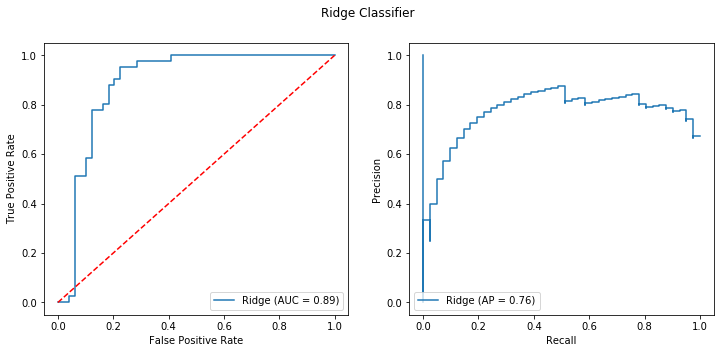

In [7]:
clf = LogisticRegression(penalty='l2', solver='lbfgs')

#Set regularization strenghts between 1e-10 and 100 by powers of 10 with 5x cross validation
c = np.logspace(-10, 2, 13) 
tuned_parameters = [{'C': c}]
n_folds = 5 

#Fit on all values of c and then find the classifier with best AUROC 
ridge = GridSearchCV(clf, tuned_parameters, cv=n_folds, refit=True)
ridge.fit(X_train, y_train)

#Print the value of alpha##
print("Best C value = %0.2f"%ridge.best_params_['C'])

#Predict the probability of positive class
y_predict = ridge.predict_proba(X_valid)[:,1]


print("AUROC for Ridge on validation set is %0.3f" % roc_auc_score(y_valid, y_predict))
print("AUPRC for Ridge on validation set is %0.3f" % average_precision_score(y_valid, y_predict))

make_auc_prc_plots(ridge, "Ridge")

joblib.dump(ridge, os.path.join(save_path, "ridge.sav"))

#### Run LASSO classification with cross validation

Best C value = 100.00
AUROC for LASSO on validation set is 0.887
AUPRC for LASSO on validation set is 0.762


['/Users/nostberg/Downloads/triage_test_models/lasso.sav']

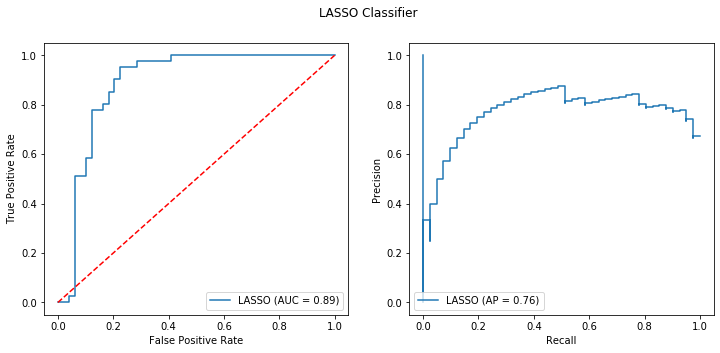

In [8]:
clf = LogisticRegression(penalty='l1', solver='liblinear')

#Set regularization strenghts between 1e-10 and 100 by powers of 10 with 5x cross validation
c = np.logspace(-10, 2, 13) 
tuned_parameters = [{'C': c}]
n_folds = 5 

#Fit on all values of c and then find the classifier with best AUROC 
lasso = GridSearchCV(clf, tuned_parameters, cv=n_folds, refit=True)
lasso.fit(X_train, y_train)

#Print the value of alpha
print("Best C value = %0.2f"%lasso.best_params_['C'])

#Predict the probability of positive class
y_predict = lasso.predict_proba(X_valid)[:,1]

print("AUROC for LASSO on validation set is %0.3f" % roc_auc_score(y_valid, y_predict))
print("AUPRC for LASSO on validation set is %0.3f" % average_precision_score(y_valid, y_predict))

make_auc_prc_plots(lasso, "LASSO")

joblib.dump(ridge, os.path.join(save_path, "lasso.sav"))

#### Run Random Forest model with cross validation 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.4s finished


Best parameters: 
 Min Sample split = 10 
 Min Sample Leaf = 1 
 Max Depth = 31 
 Bootstrap = True
AUROC for Random Forest on validation set is 0.836
AUPRC for Random Forest on validation set is 0.789


['/Users/nostberg/Downloads/triage_test_models/rf.sav']

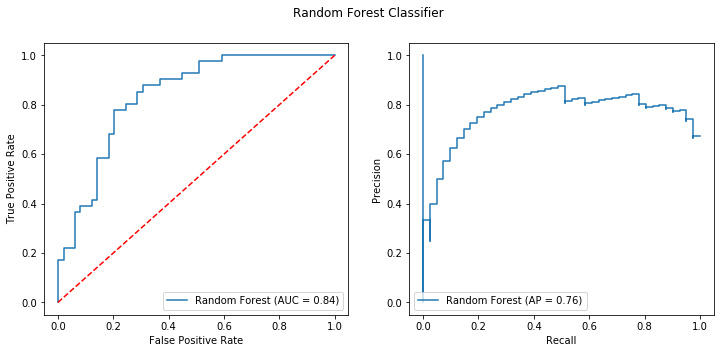

In [9]:
#Create a grid for random grid search hyperparameter tuning 
n_estimators = 1000 #Change as appropriate
min_samples_split = [2,3,5,10]
min_samples_leaf = [1,2,3,4,5]
bootstrap = [True, False]
max_depth = [int(x) for x in np.logspace(1,2.5,10)]
max_depth.append(None)

#Set up hyperparameter grid
grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


clf = RandomForestClassifier()

#Randomized search for 100 iterations
random_forest = RandomizedSearchCV(clf, param_distributions= grid, n_iter=100, verbose = 1, cv=5, n_jobs = -1)

random_forest.fit(X_train,y_train)

#Print best parameters
print("Best parameters: \n Min Sample split = %d \n Min Sample Leaf = %d \n Max Depth = %d \n Bootstrap = %s" 
      % (random_forest.best_params_["min_samples_split"],random_forest.best_params_["min_samples_leaf"] , random_forest.best_params_["max_depth"], random_forest.best_params_["bootstrap"]))

y_predict = random_forest.predict_proba(X_valid)[:,1]

print("AUROC for Random Forest on validation set is %0.3f" % roc_auc_score(y_valid, y_predict))
print("AUPRC for Random Forest on validation set is %0.3f" % average_precision_score(y_valid, y_predict))

make_auc_prc_plots(random_forest, "Random Forest")

joblib.dump(ridge, os.path.join(save_path, "rf.sav"))

#### Run LIGHTGM with cross validation

In [11]:
#Do early stopping
n_estimators = 1000 #Change as appropriate

max_depth = [int(x) for x in np.logspace(1,3,5)]
max_depth.append(-1)
num_leaves = [10,20,50,100]

grid = {'max_depth': max_depth,
       'num_leaves': num_leaves}

estimator = lgb.LGBMClassifier(n_estimators=n_estimators)

clf = RandomizedSearchCV(estimator, grid, verbose = 1, cv=5, n_jobs = -1)

clf.fit(X_train, y_train)

y_predict = clf.predict_proba(X_valid)[:,1]

print("AUROC for LGB on validation set is %0.3f" % roc_auc_score(y_valid, y_predict))
print("AUPRC for LGB on validation set is %0.3f" % average_precision_score(y_valid, y_predict))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s


AUROC for LGB on validation set is 0.861
AUPRC for LGB on validation set is 0.831


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.7s finished


#### Run FF NN with Kera/Tensorflow

In [12]:
#Hyperparameters
batch_size = 32
epochs = 100
regularization = 0.001
tf.random.set_seed(5) #Having trouble with this! Not stable result

In [13]:
#Set up early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

#Set up Keras model - 5 hidden layers, dropout, L2 reularization
model = Sequential()
model.add(Dense(1024, input_dim = X_train.shape[1], 
                activation = 'relu', 
                kernel_regularizer=l2(regularization)))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu',
               kernel_regularizer=l2(regularization)))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu',
               kernel_regularizer=l2(regularization)))
model.add(Dropout(0.2))
model.add(Dense(8, activation = 'relu',
               kernel_regularizer=l2(regularization)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid',
               kernel_regularizer=l2(regularization)))

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.AUC()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              6144      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

In [14]:
train_history = model.fit(X_train, y_train, epochs = epochs, 
          batch_size=batch_size,
         validation_data=(X_valid, y_valid), callbacks=[callback])

print("Number of EPOCHs run = %d" %len(train_history.history['loss']) )

Train on 300 samples, validate on 90 samples
Epoch 1/100
300/300 [==============================] - 1s 2ms/step - loss: 1.1660 - accuracy: 0.6267 - auc: 0.6090 - val_loss: 1.1327 - val_accuracy: 0.6000 - val_auc: 0.6995
Epoch 2/100
300/300 [==============================] - 0s 151us/step - loss: 1.0329 - accuracy: 0.7300 - auc: 0.7252 - val_loss: 1.0547 - val_accuracy: 0.6333 - val_auc: 0.7306
Epoch 3/100
300/300 [==============================] - 0s 167us/step - loss: 0.9255 - accuracy: 0.7633 - auc: 0.7487 - val_loss: 0.9128 - val_accuracy: 0.7667 - val_auc: 0.7693
Epoch 4/100
300/300 [==============================] - 0s 160us/step - loss: 0.8516 - accuracy: 0.8000 - auc: 0.7833 - val_loss: 0.8231 - val_accuracy: 0.8000 - val_auc: 0.7965
Epoch 5/100
300/300 [==============================] - 0s 151us/step - loss: 0.7503 - accuracy: 0.8333 - auc: 0.8109 - val_loss: 0.7469 - val_accuracy: 0.7889 - val_auc: 0.8210
Epoch 6/100
300/300 [==============================] - 0s 154us/step - l

AUROC for FF NN on validation set is 0.897
AUPRC for FF NN on validation set is 0.853


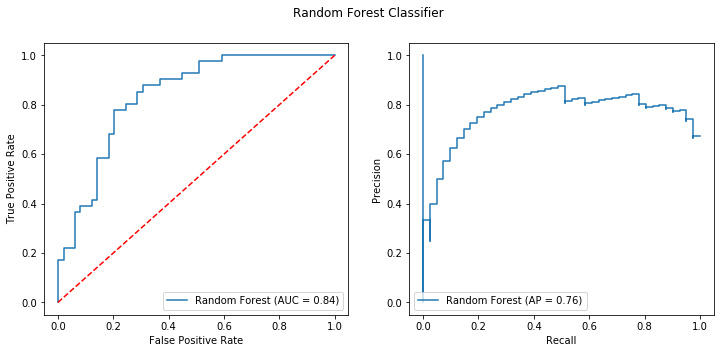

In [15]:
y_predict = model.predict(X_valid)
print("AUROC for FF NN on validation set is %0.3f" % roc_auc_score(y_valid, y_predict))
print("AUPRC for FF NN on validation set is %0.3f" % average_precision_score(y_valid, y_predict))

make_auc_prc_plots(random_forest, "Random Forest")

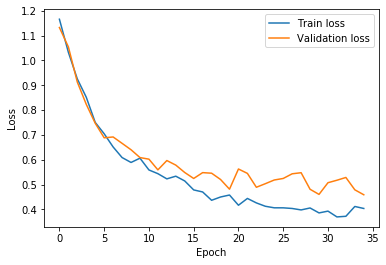

In [16]:
#Use this to diagnose overfitting...
plt.plot(range(0,len(train_history.history['loss'])), train_history.history['loss'], label="Train loss")
plt.plot(range(0,len(train_history.history['val_loss'])), train_history.history['val_loss'], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Run ablation studies

## Test time

In [215]:
#Append training and validation data together and fit best model on each 

X_train_valid = np.append(X_train, X_valid, axis = 0)
y_train_valid = np.append(y_train, y_valid)

lasso_final = lasso.best_estimator_.fit(X_train_valid, y_train_valid)

y_test_predictions = lasso_final.predict_proba(X_test)[:,1]
print("AUROC for LASSO on test set is %0.3f" % roc_auc_score(y_test, y_test_predictions))
print("AUPRC for LASSO on test set is %0.3f" % average_precision_score(y_test, y_test_predictions))

AUROC for LASSO on test set is 0.860
AUPRC for LASSO on test set is 0.755
